In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
import gym
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [71]:
class RolloutVaeDataset(torch.utils.data.Dataset):
    def __init__(self, dir_path, transform=None):
        super(RolloutVaeDataset, self).__init__()

        self.transform = transform

        self.data = []
        if (dir_path[-1] != '/'):
            dir_path += '/'
        for file in os.listdir(dir_path):
          file_np = np.load(dir_path + str(file))
          imgs = file_np['obs'] # 1000 x 64 x 64 x 3
          for curr_img in imgs:
            self.data.append(curr_img)
            #self.data.append((np.transpose(curr_img, (2, 0, 1))))

    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        # TODO
        if (self.transform):
          return self.transform(self.data[idx])
        else:
          return torch.tensor(self.data[idx])

In [72]:
class VAE(nn.Module):
    def __init__(self, device, batch_size=250):
        super(VAE, self).__init__()

        self.device = device
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2),
            nn.ReLU()
        )
        
        self.mufc = nn.Linear(1024, 32)
        self.logvarfc = nn.Linear(1024, 32)
        
        self.decoder_fc = nn.Linear(32, 1024)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1024, 128, 5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 6, stride=2),
            nn.Sigmoid(),
        )
        
        self.batch_size = batch_size
        #self.dist = torch.distributions.laplace.Laplace(0, torch.ones([50]))
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        #noise = torch.randn(self.batch_size, 32).to(self.device)
        noise = torch.randn_like(std).to(self.device)
        return mu + std * noise # z
    
    def forward(self, x):
        x = self.encoder(x)
        x = x.reshape(-1, 1024)
        mu, logvar = self.mufc(x), self.logvarfc(x)
        z = self.reparameterize(mu, logvar)
        z_ = self.decoder_fc(z)
        z_ = z_.reshape(-1, 1024, 1, 1)
        return self.decoder(z_.float()), mu, logvar
    
    def get_z(self, x):
        with torch.no_grad():
            encoded = self.encoder(x)
            return self.reparameterize(encoded)

    def loss_func(self, x, x_prime, mu, logvar):
      recon_loss = nn.BCELoss(reduction='sum')
      loss = recon_loss(x_prime, x)
      loss += -0.5 * torch.sum(1 + logvar - mu.pow(2) - torch.exp(logvar))

      return loss

In [73]:
def initialize_weights(layer):
    with torch.no_grad():
        if type(layer) == nn.Linear:
            torch.nn.init.xavier_normal_(layer.weight)
            layer.bias.data.fill_(0.01)
        if type(layer) == nn.Conv2d:
            torch.nn.init.xavier_normal_(layer.weight)
            layer.bias.data.fill_(0.01)
        if type(layer) == nn.ConvTranspose2d:
            torch.nn.init.xavier_normal_(layer.weight)
            layer.bias.data.fill_(0.01)

In [74]:
def plot_loss(losses, title, yLabel, saveFig=False, figSize=(15, 10)):
    sns.set()
    fig = plt.figure(figsize=figSize)
    ax = plt.gca()
    ax.plot(losses)
    ax.set_ylabel(yLabel)
    ax.set_xlabel('Epoch')
    plt.title(title)
    plt.show()

In [75]:
LR = 1e-3
BATCH_SIZE = 1000
USE_CUDA = True
BETAS = (0.9, 0.999) # default adam betas

use_cuda = USE_CUDA and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
NUM_WORKERS = multiprocessing.cpu_count()
print('num workers:', NUM_WORKERS)

Using device cuda
num workers: 2


In [76]:
#
#trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transforms)
#trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
#testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transforms)
#testloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

path = '/content/drive/MyDrive/env_rollouts/'
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Normalize(mean=(0,), std=(1,))])
data_train = RolloutVaeDataset(path, transforms)
trainloader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,shuffle=True)

vae = VAE(device, batch_size=BATCH_SIZE)
vae.to(device)

optim = torch.optim.Adam(vae.parameters(), lr=LR)
vae.apply(initialize_weights) 
train_losses = []

In [77]:
NUM_EPOCHS = 10

In [78]:
for epoch in range(NUM_EPOCHS):
    print('epoch: ' + str(epoch))

    epoch_losses = []
    for i, data in enumerate(trainloader, 0):
        X_batch = data.to(device, dtype=torch.float)
        X_prime, mu, logvar = vae(X_batch)
        loss = vae.loss_func(X_batch, X_prime, mu, logvar)
        optim.zero_grad()
        loss.backward()
        optim.step()

        epoch_losses.append(loss.item())

    epoch_loss = np.mean(epoch_losses)
    print('epoch loss: ' + str(epoch_loss))
    train_losses.append(epoch_loss)

epoch: 0
epoch loss: 7815737.660714285
epoch: 1
epoch loss: 7574323.261904762
epoch: 2
epoch loss: 7432809.005952381
epoch: 3
epoch loss: 7407704.553571428
epoch: 4
epoch loss: 7397695.446428572
epoch: 5
epoch loss: 7391748.172619048
epoch: 6
epoch loss: 7386417.970238095
epoch: 7
epoch loss: 7382827.226190476
epoch: 8
epoch loss: 7380620.125
epoch: 9
epoch loss: 7377782.267857143


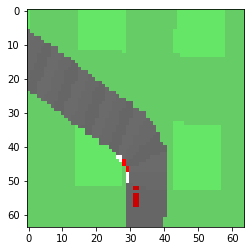

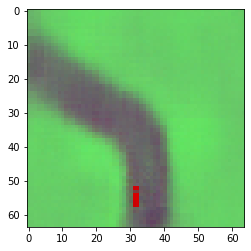

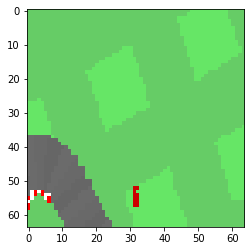

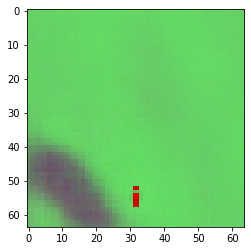

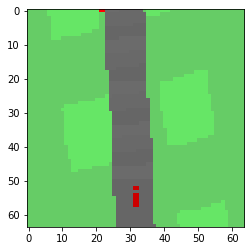

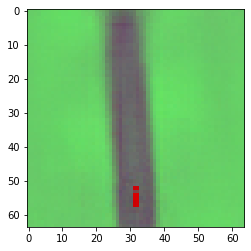

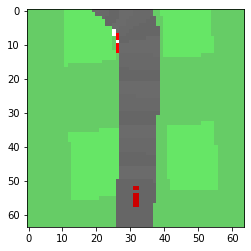

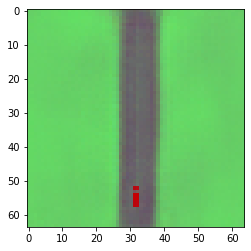

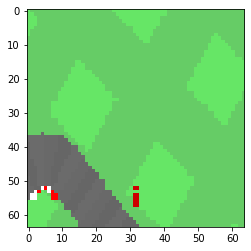

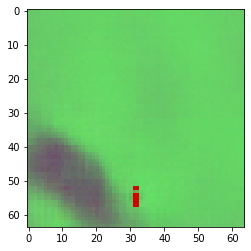

In [80]:
from PIL import Image
with torch.no_grad():
  for i, data in enumerate(trainloader, 0):
    X_batch = data.to(device, dtype=torch.float)
    #X_batch, labels = data[0].to(device), data[1].to(device)
    X_prime, mu, logvar = vae(X_batch)
    for i in range(5):
      x_orig = np.transpose(X_batch[i].cpu().numpy(), (1, 2, 0))
      plt.imshow(x_orig)
      plt.show()
      x_recon = np.transpose(X_prime[i].cpu().numpy(), (1, 2, 0))
      plt.imshow(x_recon)
      plt.show()
    break

83715